# TOTUO TAMOKWE ULRICH VIANNEY

# TP 2.1 : Stratégie de couverture de Black-Scholes

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm

**Objectif :**  
Dans ce TP, nous allons implémenter la stratégie de couverture optimale dans le cadre du modèle de Black-Scholes et simuler plusieurs trajectoires du processus de prix $ (S_t)_{0 \leq t \leq T} $ d’un actif sous-jacent.

### Simuler des trajectoires du processus de Black-Scholes

On commence par simuler $ m = 10\,000 $ trajectoires discrètes du processus $ (S_t)_{0 \leq t \leq T} $ sur une grille de temps définie par $ n = 1\,000 $ et $ T = 1.5 $. Le processus est donné par :

$$
S_t = S_0 \exp{\left( \left( \mu - \frac{\sigma^2}{2} \right)t + \sigma W_t \right)}, \quad t \geq 0
$$

avec $ W_t $ un mouvement brownien, $ S_0 = 100 $, $ \sigma = 0.3 $, et trois valeurs de tendance $ \mu \in \{ 0.02, 0.05, 0.45 \} $.

### Paramètres :

- Nombre de trajectoires : $ m = 10\,000 $
- Grille de temps : $ n = 1\,000 $
- Temps final : $ T = 1.5 $
- Prix initial : $ S_0 = 100 $
- Volatilité : $ \sigma = 0.3 $
- Tendance : $ \mu \in \{ 0.02, 0.05, 0.45 \} $


## Voici le code qui génère les trajectoires du mouvement brownien, puis celles du processus $St$.

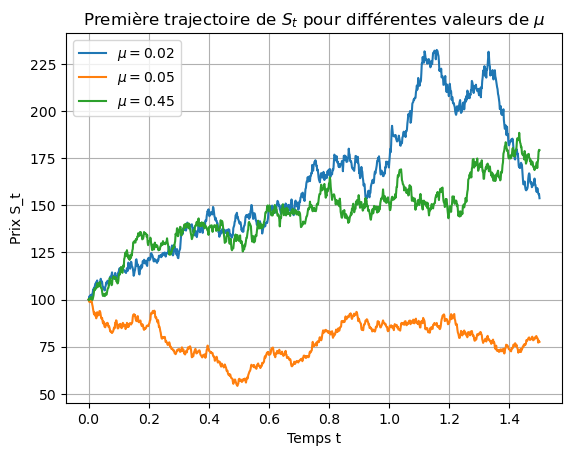

In [3]:
# Paramètres
m = 10000
n = 1000
T = 1.5
S_0 = 100
sigma = 0.3
mu_values = [0.02, 0.05, 0.45]

# Fonction de simulation du mouvement brownien
def simulate_brownian(n, m, T=T):
    delta_T = T / n
    Z = np.random.normal(0, 1, (m, n))  
    W = np.zeros((m, n + 1))  
    W[:, 1:] = np.cumsum(np.sqrt(delta_T) * Z, axis=1)
    t_values = np.linspace(0, T, n + 1)
    return W, t_values

# Fonction qui simule les trajectoires de S_t
def process(n, m, mu, sigma, T=T, S_0=S_0):
    W, t_values = simulate_brownian(n, m, T)
    return S_0 * np.exp((mu - 0.5 * sigma**2) * t_values + sigma * W)

# Générer les trajectoires pour les différentes valeurs de mu
for mu in mu_values:
    S = process(n, m, mu, sigma, T, S_0)
    plt.plot(np.linspace(0, T, n + 1), S[0], label=f"$\mu = {mu}$")

plt.xlabel("Temps t")
plt.ylabel("Prix S_t")
plt.title("Première trajectoire de $S_t$ pour différentes valeurs de $\mu$")
plt.legend()
plt.grid(True)
plt.show()

## Statistiques des trajectoires

Nous calculons ensuite la moyenne et la variance à chaque instant $ t $ pour les différentes valeurs de $ \mu $.


In [4]:
def statistics(S): 
    mean_S = np.mean(S, axis=0)
    var_S = np.var(S, axis=0)
    return mean_S, var_S

for mu in mu_values:
    S = process(n, m, mu, sigma, T, S_0)
    mean_S, var_S = statistics(S)
    print(f"mu = {mu}")
    print(f"Moyenne finale de S_T: {mean_S[-1]}")
    print(f"Variance finale de S_T: {var_S[-1]}\n")

mu = 0.02
Moyenne finale de S_T: 102.65139598338911
Variance finale de S_T: 1522.6419543087925

mu = 0.05
Moyenne finale de S_T: 107.67827551961464
Variance finale de S_T: 1672.4919575332956

mu = 0.45
Moyenne finale de S_T: 196.2863295542311
Variance finale de S_T: 5492.9702016816245



### Interprétation des résultats

Les résultats montrent que lorsque la tendance $ \mu $ augmente, non seulement la moyenne du processus $ S_T $ augmente, mais aussi sa variance. Cela est cohérent avec l'intuition, car une tendance plus élevée reflète une croissance plus rapide du prix moyen de l'actif. En outre, la volatilité impacte davantage les trajectoires lorsque $ \mu $ est plus élevé, ce qui explique l'augmentation de la variance.

Théoriquement, la moyenne et la variance du prix final $ S_T $ peuvent être exprimées comme suit :

$$
E[S_T] = S_0 \exp{(\mu T)}
$$

$$
\text{Var}(S_T) = S_0^2 \exp{((2\mu - \sigma^2)T)} \cdot \text{Var}(\exp{(\sigma W_T)})
$$

Ces expressions confirment que la moyenne est croissante avec $ \mu $, tandis que la variance dépend à la fois de $ \mu $ et de $ \sigma $, avec un effet plus marqué de $ \sigma $ sur la dispersion des trajectoires.


## 2. On note

$$
e^{-rT} X_T^n(S, K) := BS(S_0, K, T) + \sum_{i=1}^{n} \Delta t_n^{i-1} (S_{t_n^{i-1}}, K) \left( e^{-r t_n^i} S_{t_n^i} - e^{-r t_n^{i-1}} S_{t_n^{i-1}} \right)
$$

(a) Simulez $ m = 10\,000 $ réalisations de $ X_T^n(S, K) $ pour chacune des trois valeurs de $ \mu $. On prendra $ r = 0.05 $. On utilisera $ K \in \{80, 82, 84, \ldots, 120\} $.


In [5]:
# Paramètres
r = 0.05
k_values = np.arange(80, 121)

# Calcul du prix (Call) en Absence d’Opportunité d’Arbitrage (AOA) d’une option d’achat européenne
def black_scholes_price(S_0, K, T, sigma, r=r):
    k = K * np.exp(-r * T)
    v = sigma ** 2 * T
    base = np.log(S_0 / k) / np.sqrt(v)
    dm, dp = (base - 0.5 * np.sqrt(v), base + 0.5 * np.sqrt(v))
    return S_0 * norm.cdf(dp) - k * norm.cdf(dm)

# Calcul de Delta, la stratégie de couverture Black-Scholes
def delta(S, K, T, t, sigma, r=r):
    k = K * np.exp(-r * (T - t))
    v = sigma ** 2 * (T - t)
    dp = np.log(S / k) / np.sqrt(v) + 0.5 * np.sqrt(v)
    return norm.cdf(dp)

# Fonction pour générer un nouveau processus de prix S_t
def new_process(n, T, mu, sigma, S_0=S_0):
    delta_T = T / n
    Zi = delta_T ** 0.5 * np.random.randn(n)
    W = np.zeros((n + 1,))
    W[1:] = np.cumsum(Zi)
    t_values = np.linspace(0, T, n + 1)
    exponents = (mu - 0.5 * sigma ** 2) * t_values + sigma * W
    return S_0 * np.exp(exponents)

# Fonction qui calcule Xn_T
def xtn(n, T, K, S_0, mu, sigma, r=0.05):
    bs = black_scholes_price(S_0, K, T, sigma, r)
    t_vals = np.linspace(0, T, n + 1)
    t_vals_dec = t_vals[:-1]
    t_vals = t_vals[1:]
    deltas = delta(S_0, K, T, t_vals_dec, sigma, r)
    St = new_process(n, T, mu, sigma, S_0)
    St_dec = St[:-1]
    St = St[1:]
    res = bs + np.sum(deltas * (np.exp(-r * t_vals) * St - np.exp(-r * t_vals_dec) * St_dec), axis=0)
    return np.exp(r * T) * res

# Simulation des réalisations
sample_data = []
for K in k_values:
    print(f"Calcul des échantillons pour K={K:.3f}")
    K_sample_data = []
    print("  Calcul pour mu =", end='\t')
    for mu in mu_values:
        print(f"{mu:.3f}", end='\t')
        K_sample_data.append([xtn(n, T, K, S_0, mu, sigma) for _ in range(m)])
    print()
    sample_data.append(K_sample_data)

sample_data = np.array(sample_data)

print("Dimensions de sample_data:", sample_data.shape)

Calcul des échantillons pour K=80.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=81.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=82.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=83.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=84.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=85.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=86.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=87.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=88.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=89.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=90.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=91.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des échantillons pour K=92.000
  Calcul pour mu =	0.020	0.050	0.450	
Calcul des é

(b) Calculez la moyenne empirique et la variance empirique de ces trois variables aléatoires et commentez.

Pour chaque valeur de $ \mu $, nous allons calculer la moyenne empirique $ \bar{X}_T^n $ et la variance empirique $ V(X_T^n) $ de $ X_T^n(S, K) $.

Les formules pour la moyenne et la variance sont données par :

$$
\bar{X}_T^n = \frac{1}{m} \sum_{j=1}^{m} X_T^n(S, K)_j
$$

$$
V(X_T^n) = \frac{1}{m-1} \sum_{j=1}^{m} (X_T^n(S, K)_j - \bar{X}_T^n)^2
$$

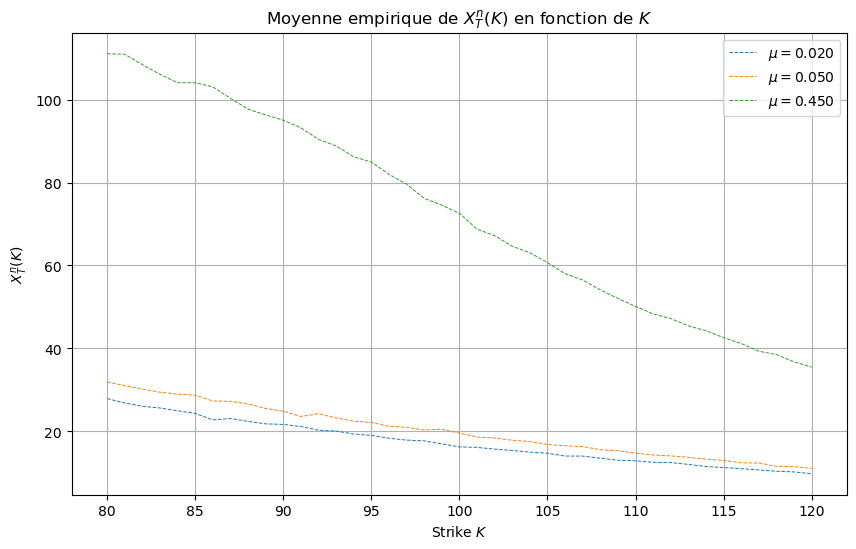

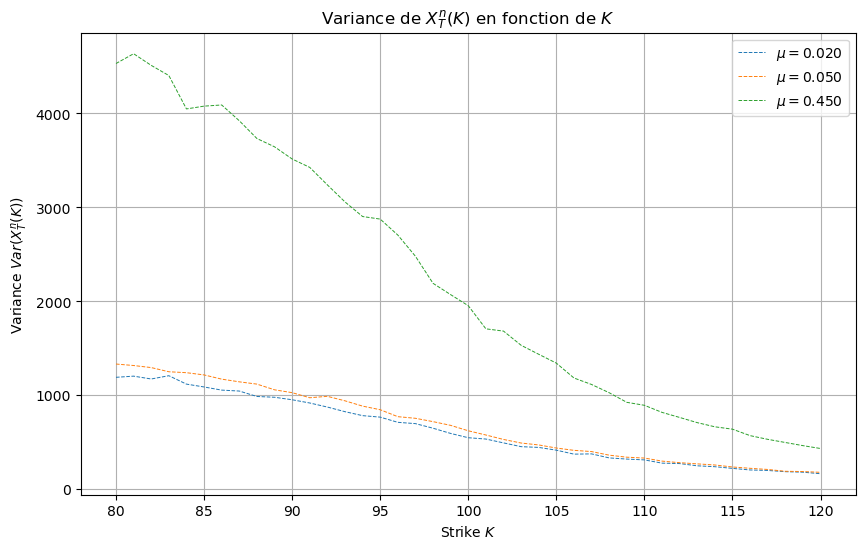

In [6]:
# Calcul de la moyenne empirique
mean_matrix = sample_data.mean(axis=2)

# Tracé de la moyenne empirique
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.set_xlabel("Strike $K$")
ax.set_ylabel("$X_T^n(K)$")
ax.set_title("Moyenne empirique de $X_T^n(K)$ en fonction de $K$")

for i, mu in enumerate(mu_values):
    ax.plot(k_values, mean_matrix[:, i], linestyle='--', label=r"$\mu=%.3f$" % mu, linewidth=0.7)

ax.legend()
ax.grid()
plt.show()

# Calcul de la variance empirique
var_matrix = sample_data.var(axis=2)

# Tracé de la variance empirique
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.set_xlabel("Strike $K$")
ax.set_ylabel("Variance $Var(X_T^n(K))$")
ax.set_title("Variance de $X_T^n(K)$ en fonction de $K$")

for i, mu in enumerate(mu_values):
    ax.plot(k_values, var_matrix[:, i], linestyle='--', label=r"$\mu=%.3f$" % mu, linewidth=0.7)

ax.legend()
ax.grid()
plt.show()

### Commentaire :

L'analyse des résultats montre que, pour des valeurs élevées de la tendance $ \mu $, qui correspondent à une moyenne plus importante du prix de l'actif sous-jacent ainsi qu'à une variance accrue à l'échéance $ T $, nous observons une diminution plus prononcée de la valeur du portefeuille $ X_T^n(K) $ en fonction du prix d'exercice $ K $. Cela se manifeste par une pente plus abrupte de la courbe lorsque $ \mu $ augmente.

En effet, une tendance positive plus forte indique un rendement attendu plus élevé sur l'actif à l'échéance $ T $, mais elle s'accompagne également d'une plus grande incertitude concernant les variations de prix. Cette incertitude se traduit par une variance élevée, ce qui signifie que les prix des actifs peuvent fluctuer de manière plus significative. Par conséquent, lorsqu'un investisseur choisit un prix d'exercice $ K $ plus élevé, la valeur actuelle des options d'achat devient plus sensible aux fluctuations du marché.

Ainsi, pour un prix d'exercice $ K $ supérieur, même une légère augmentation du prix de l'actif sous-jacent peut ne pas suffire à compenser l'effet de la variance accrue sur la valeur de l'option. Cela signifie que, malgré un rendement attendu plus élevé, le risque associé à la volatilité du prix de l'actif augmente, rendant les options avec des prix d'exercice plus élevés moins attrayantes.

En résumé, bien que des valeurs élevées de $ \mu $ puissent suggérer une croissance future prometteuse, elles viennent avec des implications de risque qui doivent être soigneusement considérées. Les investisseurs doivent donc évaluer leur tolérance au risque lorsqu'ils choisissent un prix d'exercice, car un prix d'exercice élevé pourrait rapidement réduire la valeur de l'option, même dans un contexte de forte tendance positive.

(c) Calculez les gains et pertes correspondantes :

Nous définissons les gains et pertes comme suit :

$$
P_L^n(T)(S, K) := X_T^n(S, K) - (S_T - K)^+
$$

où $ (S_T - K)^+ $ représente la valeur d'une option d'achat à l'échéance $ T $, qui est positive si $ S_T > K $ et nulle sinon.

In [7]:
# Définition de la fonction pour calculer les gains et pertes
def profit_loss(n, T, K, S_0, mu, sigma, r=r):
    # Calcul du prix Black-Scholes
    bs = black_scholes_price(S_0, K, T, sigma, r)
    # Génération des valeurs temporelles
    t_vals = np.linspace(0, T, n+1, endpoint=True)
    t_vals_dec = t_vals[:-1]
    t_vals = t_vals[1:]
    # Calcul des deltas
    deltas = delta(S_0, K, T, t_vals_dec, sigma, r)
    # Simulation du processus sous-jacent
    St = new_process(n, T, mu, sigma, S_0)
    Sfinal = St[-1]
    St_dec = St[:-1]
    St = St[1:]
    
    # Calcul des gains ajustés
    res = bs + np.sum(deltas * (np.exp(-r * t_vals) * St - np.exp(-r * t_vals_dec) * St_dec), axis=0)
    res = np.exp(r * T) * res
    return res - max(0, Sfinal - K)

# Définition des valeurs de n à évaluer
n_values = [100, 1000]
pnl_sample_data = []

print("=== Calcul des Gains et Pertes ===")
for n in n_values:
    print(f"Calcul des échantillons pour n={n}...")
    n_sample_data = []
    for K in k_values:
        print(f"  Traitement pour K={K:.3f}...", end='')
        K_sample_data = []
        for mu in mu_values:
            # Calcul des gains et pertes pour chaque combinaison de K et mu
            K_sample_data.append([profit_loss(n, T, K, S_0, mu, sigma) for _ in range(m)])
        print(' terminé.')
        n_sample_data.append(K_sample_data)
    pnl_sample_data.append(n_sample_data)

# Conversion des données échantillonnées en tableau NumPy
pnl_sample_data = np.array(pnl_sample_data)
print(f"Taille des données de gains et pertes : {pnl_sample_data.shape}")

# Calcul de la moyenne et de la variance
mean_matrix = np.mean(pnl_sample_data, axis=-1)
var_matrix = np.var(pnl_sample_data, axis=-1, ddof=1)

print("=== Résultats de Gains et Pertes ===")
print(f"Moyenne des gains et pertes : \n{mean_matrix}")
print(f"Variance des gains et pertes : \n{var_matrix}")

=== Calcul des Gains et Pertes ===
Calcul des échantillons pour n=100...
  Traitement pour K=80.000... terminé.
  Traitement pour K=81.000... terminé.
  Traitement pour K=82.000... terminé.
  Traitement pour K=83.000... terminé.
  Traitement pour K=84.000... terminé.
  Traitement pour K=85.000... terminé.
  Traitement pour K=86.000... terminé.
  Traitement pour K=87.000... terminé.
  Traitement pour K=88.000... terminé.
  Traitement pour K=89.000... terminé.
  Traitement pour K=90.000... terminé.
  Traitement pour K=91.000... terminé.
  Traitement pour K=92.000... terminé.
  Traitement pour K=93.000... terminé.
  Traitement pour K=94.000... terminé.
  Traitement pour K=95.000... terminé.
  Traitement pour K=96.000... terminé.
  Traitement pour K=97.000... terminé.
  Traitement pour K=98.000... terminé.
  Traitement pour K=99.000... terminé.
  Traitement pour K=100.000... terminé.
  Traitement pour K=101.000... terminé.
  Traitement pour K=102.000... terminé.
  Traitement pour K=103.000

(d) Pour chaque valeur de $ \mu $, affichez la moyenne et la variance empirique de $ P_L^n(T)(S, K) $ en fonction de $ K $. Refaites avec un $ n = 100 $ plus petit et comparez.

### Formules

Pour chaque valeur de $ \mu $, nous allons calculer la moyenne empirique et la variance empirique de $ P_L^n(T)(S, K) $ :

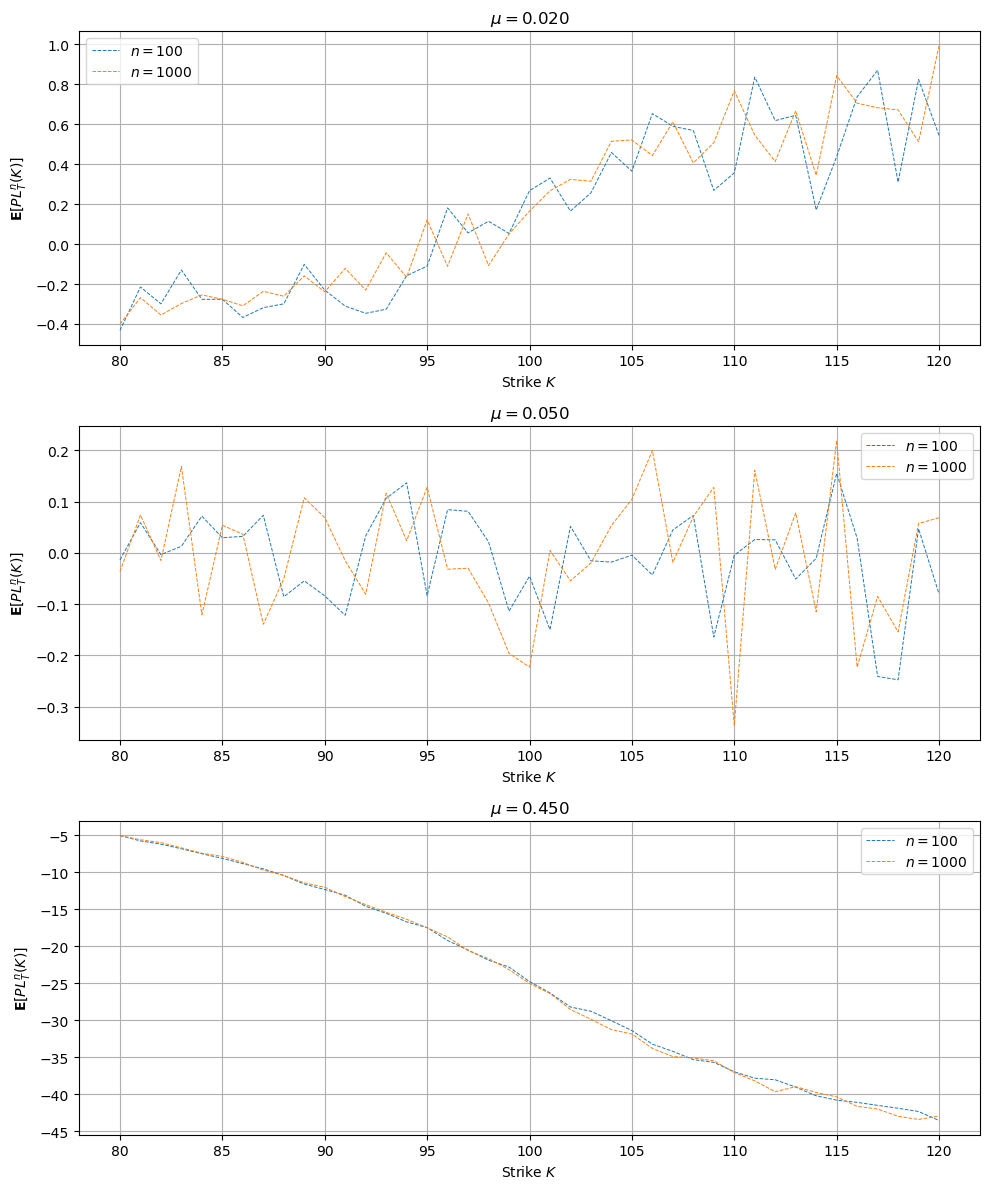

In [9]:
# === Moyenne des Gains et Pertes ===
fig, axes = plt.subplots(3, 1, figsize=(10, 12), dpi=100)

for i, mu in enumerate(mu_values):
    for j, n in enumerate(n_values):
        axes[i].plot(
            k_values, mean_matrix[j, :, i],
            linestyle='--', label=r"$n=%d$" % n, linewidth=0.7
        )
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathbf{E}[PL_T^n(K)]$")
    axes[i].grid()

fig.tight_layout()
plt.show()

### Commentaire sur la moyenne des gains et pertes

Nous observons que pour chaque valeur de $ \mu $, la moyenne des gains et pertes évolue différemment en fonction du strike $ K $. Une tendance plus forte (valeurs de $ \mu $ plus élevées) entraîne généralement une augmentation de la moyenne des gains pour des valeurs de $ K $ inférieures, mais avec une plus forte variabilité lorsque $ K $ approche le prix de l'actif sous-jacent à $ T $. Le choix du pas de simulation n'affecte pas considérablement les résultats, ce qui indique que les estimations restent robustes avec $ n=100 $.

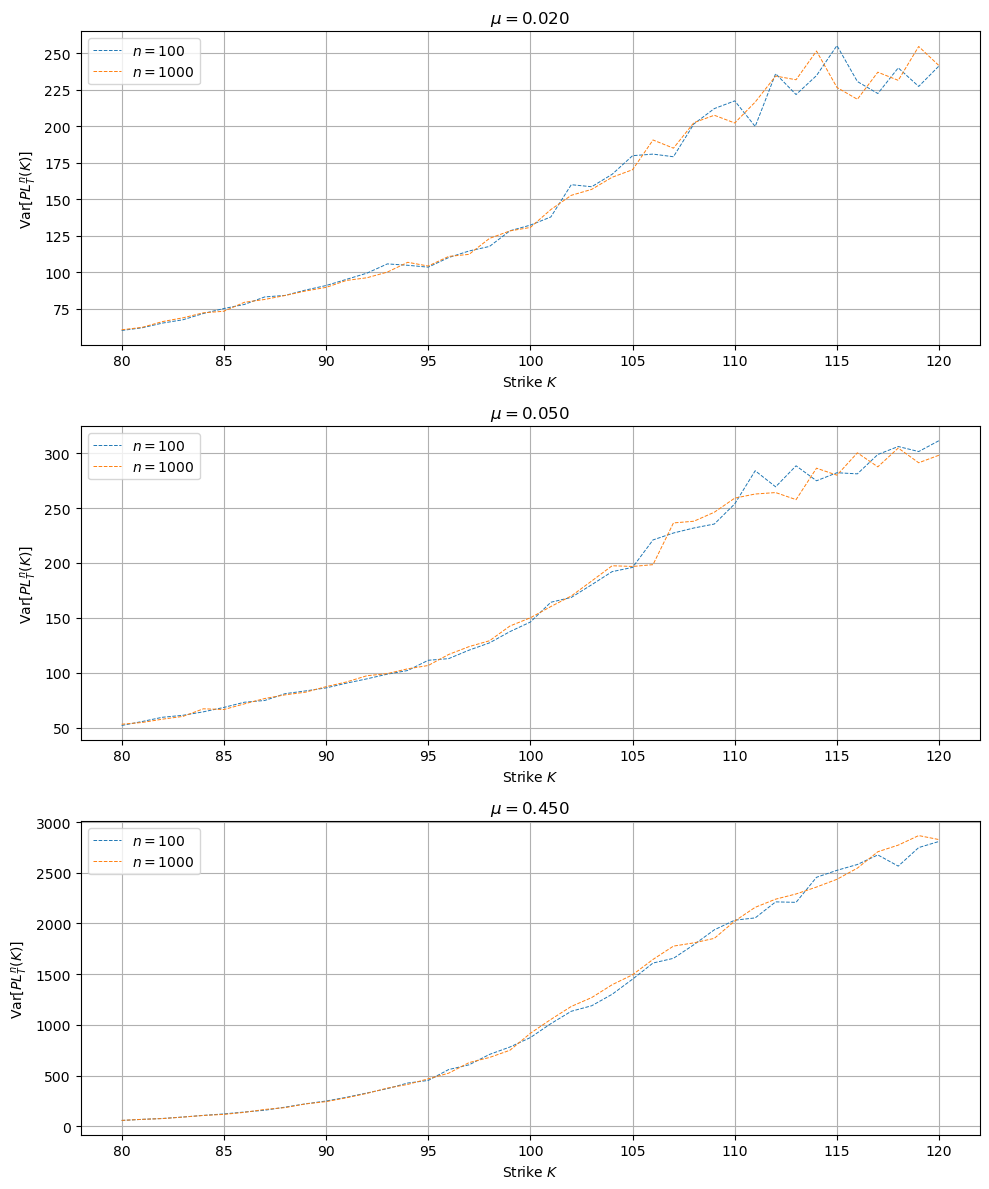

In [10]:
# === Variance des Gains et Pertes ===
fig, axes = plt.subplots(3, 1, figsize=(10, 12), dpi=100)

for i, mu in enumerate(mu_values):
    for j, n in enumerate(n_values):
        axes[i].plot(
            k_values, var_matrix[j, :, i],
            linestyle='--', label=r"$n=%d$" % n, linewidth=0.7
        )
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathrm{Var}[PL_T^n(K)]$")
    axes[i].grid()

fig.tight_layout()
plt.show()

### Commentaire sur la variance des gains et pertes

La variance des gains et pertes montre comment l'incertitude évolue avec le strike $ K $. Pour des valeurs de $ \mu $ plus élevées, nous remarquons une variance accrue, particulièrement lorsque $ K $ s'éloigne du prix de l'actif sous-jacent. Cela souligne l'effet de la volatilité sur les gains potentiels et les pertes. Le changement du pas de simulation ($ n=100 $ vs $ n=1000 $) a un impact limité sur la variance, ce qui renforce la stabilité des résultats.